# DEG identification

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc

In [2]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/'
outdir = indir

In [4]:
gene_meta = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/gencode.v33.basic.annotation.gene.flat.tsv.gz', sep='\t', index_col=8)
gene_meta

,chrom,source,feature,start,end,score,strand,phase,transcript_id,gene_type,...,gene_name,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,hgnc_id,havana_gene,tag
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,chr1,HAVANA,gene,11869,14409,.,+,.,NaN,transcribed_unprocessed_pseudogene,...,DDX11L1,NaN,NaN,NaN,NaN,NaN,2,HGNC:37102,OTTHUMG00000000961.2,NaN
ENSG00000227232.5,chr1,HAVANA,gene,14404,29570,.,-,.,NaN,unprocessed_pseudogene,...,WASH7P,NaN,NaN,NaN,NaN,NaN,2,HGNC:38034,OTTHUMG00000000958.1,NaN
ENSG00000278267.1,chr1,ENSEMBL,gene,17369,17436,.,-,.,NaN,miRNA,...,MIR6859-1,NaN,NaN,NaN,NaN,NaN,3,HGNC:50039,NaN,NaN
ENSG00000243485.5,chr1,HAVANA,gene,29554,31109,.,+,.,NaN,lncRNA,...,MIR1302-2HG,NaN,NaN,NaN,NaN,NaN,2,HGNC:52482,OTTHUMG00000000959.2,ncRNA_host
ENSG00000284332.1,chr1,ENSEMBL,gene,30366,30503,.,+,.,NaN,miRNA,...,MIR1302-2,NaN,NaN,NaN,NaN,NaN,3,HGNC:35294,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,chrM,ENSEMBL,gene,14149,14673,.,-,.,NaN,protein_coding,...,MT-ND6,NaN,NaN,NaN,NaN,NaN,3,HGNC:7462,NaN,NaN
ENSG00000210194.1,chrM,ENSEMBL,gene,14674,14742,.,-,.,NaN,Mt_tRNA,...,MT-TE,NaN,NaN,NaN,NaN,NaN,3,HGNC:7479,NaN,NaN
ENSG00000198727.2,chrM,ENSEMBL,gene,14747,15887,.,+,.,NaN,protein_coding,...,MT-CYB,NaN,NaN,NaN,NaN,NaN,3,HGNC:7427,NaN,NaN


In [5]:
adata = anndata.read_h5ad(f'{indir}rna_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 29000 × 33387
    obs: 'Class', 'Supercluster', 'Clusters', 'Age', 'Donor', 'Sex', 'Tissue', 'MajorType', 'Prob'

In [6]:
adata.var['ncell'] = adata.X.getnnz(axis=0)
adata = adata[:, (adata.var['ncell']>10) & (adata.var.index.isin(gene_meta.index))].copy()


In [7]:
adata.obs['TotalUMI'] = adata.X.sum(axis=1).A1


In [8]:
adata.X.data = adata.X.data / np.repeat(adata.obs['TotalUMI'].values, adata.X.getnnz(axis=1)) * adata.obs['TotalUMI'].median()


In [9]:
sc.pp.log1p(adata)

In [10]:
adata.var["mean"] = adata.X.mean(axis=0).A1
adata.var["std"] = (adata.X.multiply(adata.X)).mean(axis=0).A1 - (
    adata.var["mean"].values ** 2
)
print(adata.var["std"].min())

3.7919453461654484e-05


In [11]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'msn': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['msn'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']


In [12]:
expr = pd.DataFrame([adata.X[adata.obs['MajorType']==xx].mean(axis=0).A.ravel() for xx in leg['all']], index=leg['all'], columns=adata.var.index)


In [13]:
data = {xx:adata.X[adata.obs['MajorType']==xx].toarray() for xx in leg['all']}


In [14]:
import os
from scipy.stats import ranksums, kruskal
from concurrent.futures import ProcessPoolExecutor, as_completed
from statsmodels.sandbox.stats.multicomp import multipletests as FDR


In [15]:
for group in ['all', 'neu', 'exc', 'inh']:
    genefilter = (adata.X[adata.obs['MajorType'].isin(leg[group])].getnnz(axis=0) > 10)
    stats = []
    for i in range(adata.shape[1]):
        if genefilter[i]:
            tmp = [data[ct][:,i] for ct in leg[group]]
            xx, yy = kruskal(*tmp)
            stats.append([xx, yy])
    stats = np.array(stats)
    stats[:, 1] = FDR(stats[:, 1], 0.01, "fdr_bh")[1]
    stats = pd.DataFrame(stats, columns=['stats', 'fdr'], index=adata.var.index[genefilter])
    stats.to_hdf(f'{outdir}{group}_deg_stats.hdf', key='data')
    print(group)
    

all
neu
exc
inh


In [16]:
leg = leg['all']
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]


In [17]:
def diff_ranksum(c1, c2):
    global data
    # print(c1, c2)
    fc = (data[c1].mean(axis=0) + 0.01) / (data[c2].mean(axis=0) + 0.01)
    pv = np.zeros(len(fc))
    for i in range(len(pv)):
        pv[i] = ranksums(data[c1][:, i], data[c2][:, i])[1]
    fdr = FDR(pv, 0.01, "fdr_bh")[1]
    return [c1, c2, fc, fdr]
    

In [18]:
os.makedirs(f'{outdir}DEG/', exist_ok=True)

In [20]:
cpu = 32
with ProcessPoolExecutor(cpu) as executor:
    futures = []
    for c1 in range(len(leg)-1):
        for c2 in range(c1+1, len(leg)):
            future = executor.submit(
                diff_ranksum,
                c1=leg[c1],
                c2=leg[c2],
            )
            futures.append(future)

    result = []
    for future in as_completed(futures):
        result.append(future.result())
        # c1, c2 = result[-1][0], result[-1][1]
        # print(f'{leg[c1]} vs {leg[c2]} finished')
        

In [21]:
for xx in result:
    np.savez(f'{outdir}DEG/{xx[0]}-{xx[1]}.npz', fc=xx[2], fdr=xx[3])
    

In [22]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [26]:
count = pd.DataFrame(index=leg, columns=leg).fillna(0)
for xx in result:
    count.loc[xx[0], xx[1]] = np.sum(np.logical_and(np.abs(np.log2(xx[2]))>1, xx[3]<1e-3))

count = count + count.T


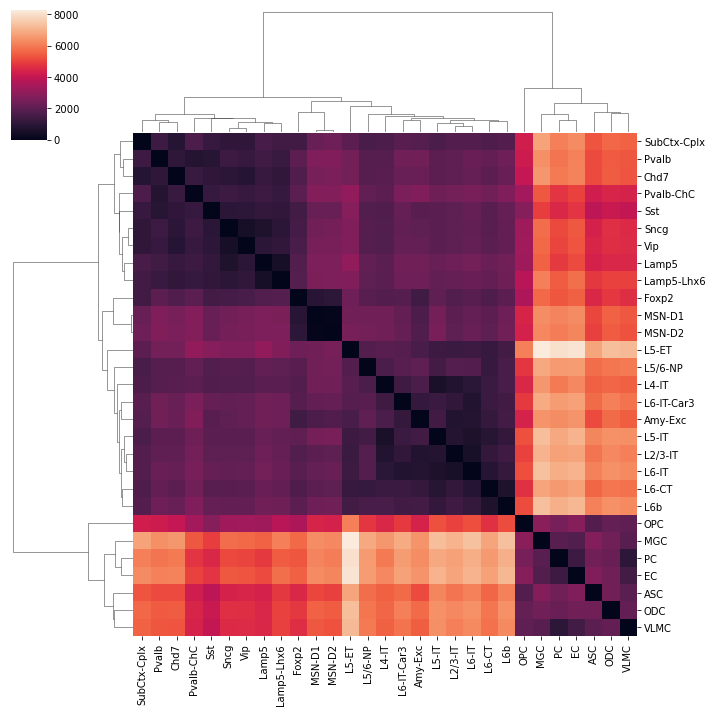

In [28]:
sns.clustermap(count, xticklabels=legname, yticklabels=legname)

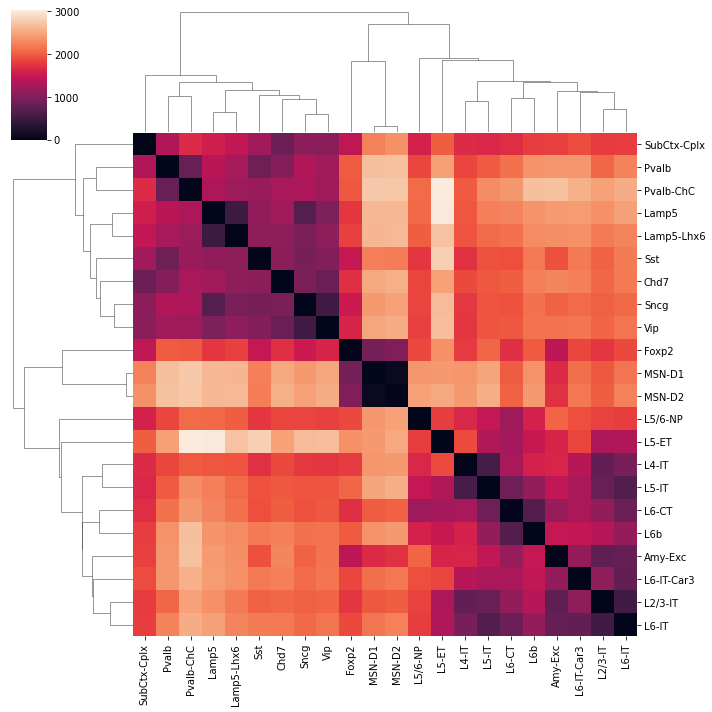

In [29]:
sns.clustermap(count.loc[leg[:22], leg[:22]], xticklabels=legname[:22], yticklabels=legname[:22])

In [30]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from ALLCools.plot import *
from ALLCools.clustering import significant_pc_test, tsne

In [31]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f"{name}_{i}"] = adata.obsm[f"X_{name}"][:, i]
    return adata

In [32]:
model = TruncatedSVD(n_components=50)
data_reduce = model.fit_transform(adata.X)
data_reduce /= model.singular_values_

In [33]:
adata.obsm['pca_all'] = data_reduce.copy()


In [34]:
significant_pc_test(adata, p_cutoff=0.1, update=False, obsm="pca_all")

49 components passed P cutoff of 0.1.


49

In [35]:
npc = 50
adata.obsm['X_pca'] = normalize(data_reduce[:, :npc], axis=1)


In [36]:
tsne(
    adata,
    obsm="X_pca",
    metric="euclidean",
    exaggeration=-1,
    perplexity=50,
    n_jobs=-1,
)
dump_embedding(adata, "tsne")
adata.obsm[f"u{npc}_tsne"] = adata.obsm["X_tsne"].copy()


In [37]:
ds = 0.5
coord_base = 'tsne'


In [38]:
import hba_data
ctdict = hba_data.internal.celltype.CellType.majortype_palette()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


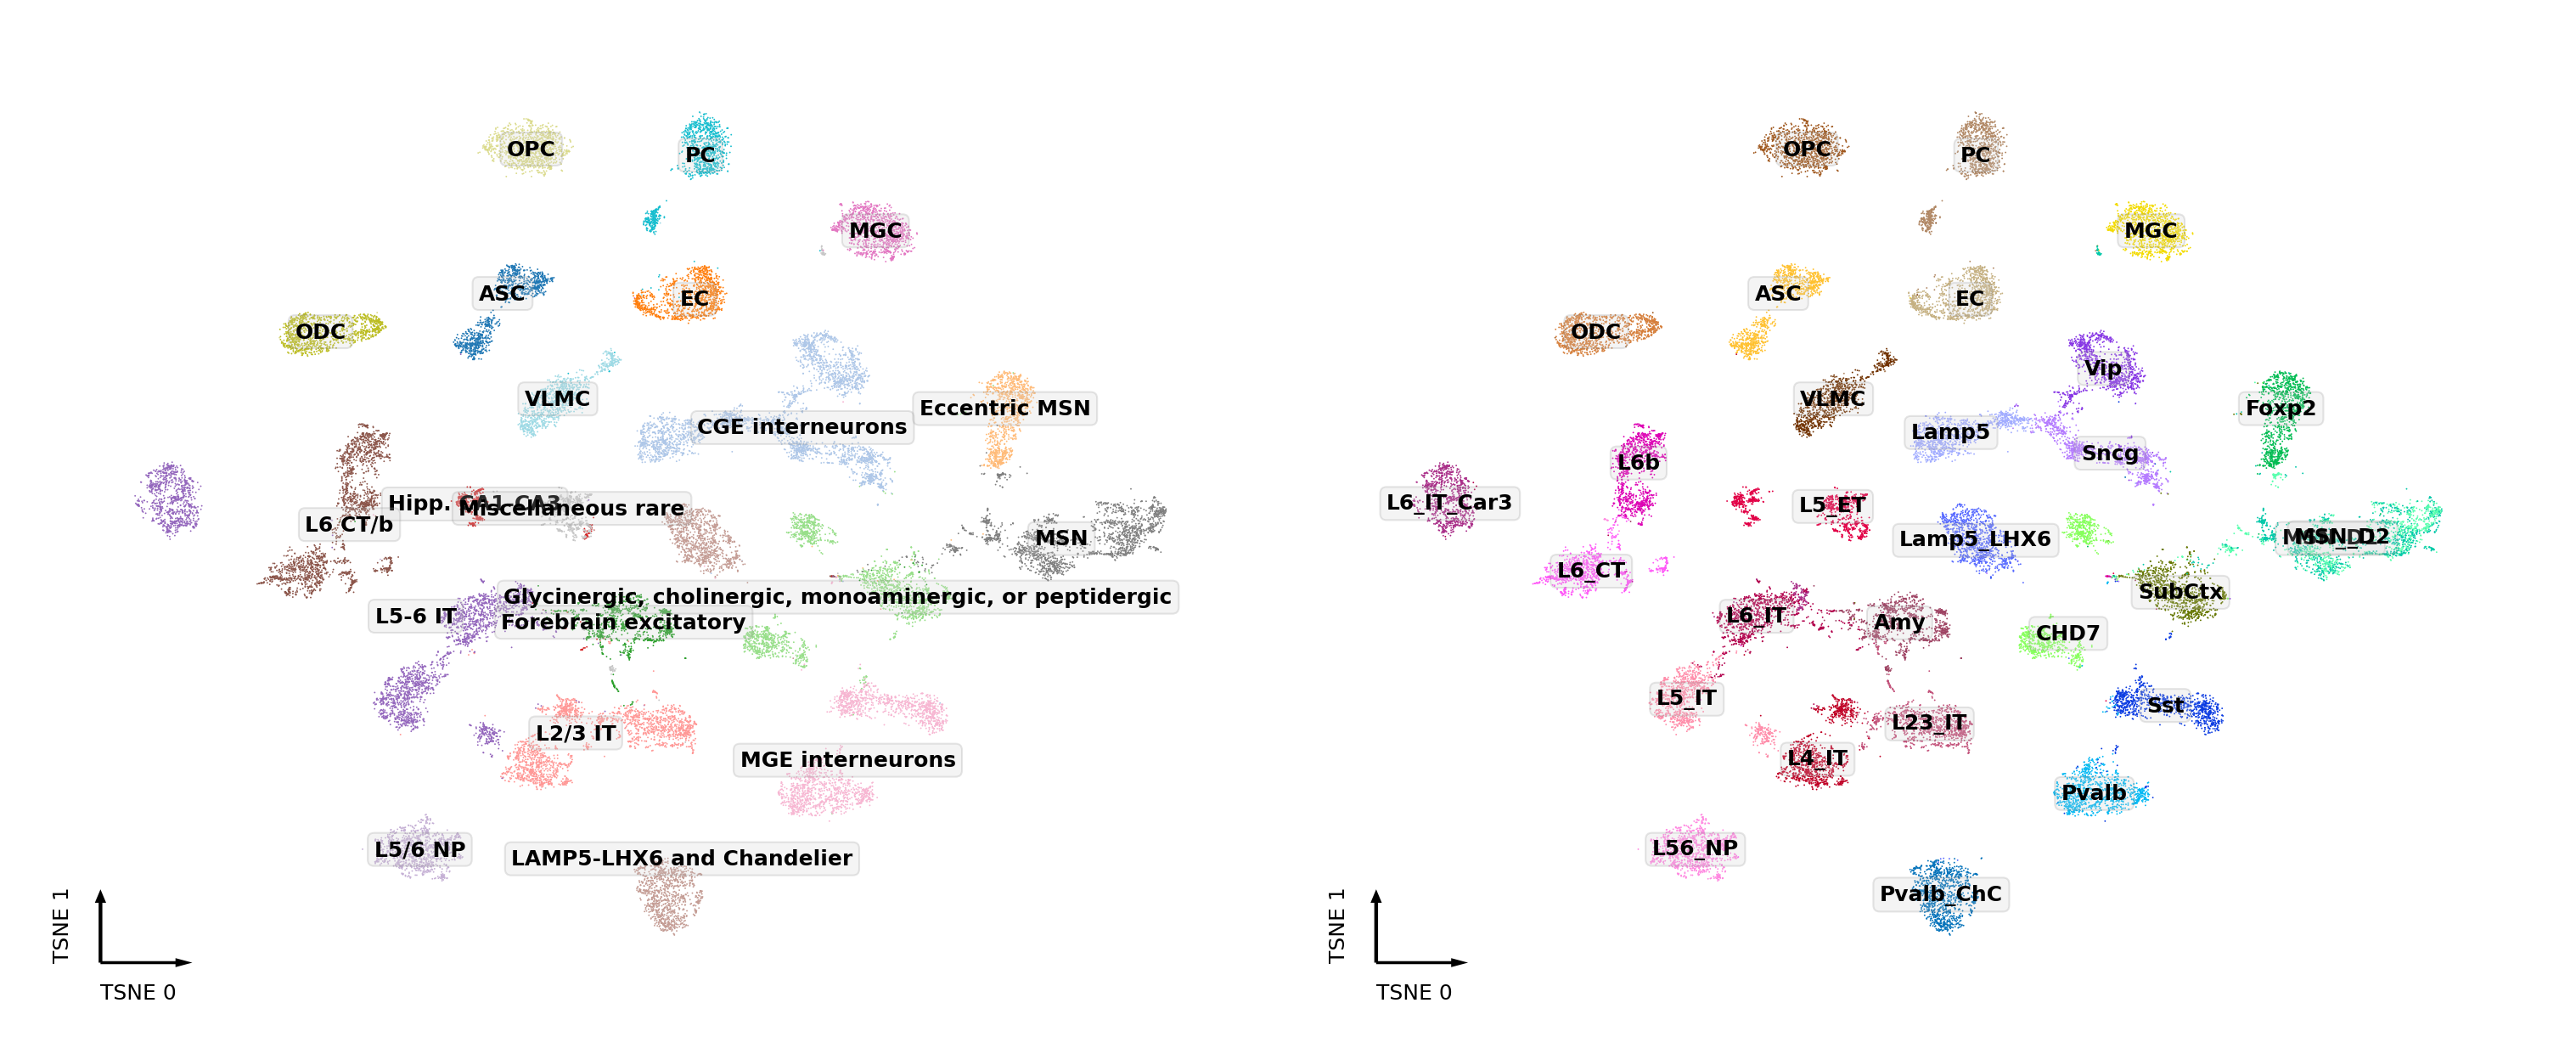

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300, constrained_layout=True, sharex='all', sharey='all')
ax = axes[0]
tmp = adata.obs['Supercluster'].value_counts()
tmp = adata.obs.loc[adata.obs['Supercluster'].isin(tmp.index[tmp>50])]
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='Supercluster',
                        text_anno='Supercluster',
                        palette='tab20',
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )
ax = axes[1]
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base=coord_base,
                        s=ds,
                        hue='MajorType',
                        text_anno='MajorType',
                        palette=ctdict,
                        labelsize=6,
                        max_points=None,
                        scatter_kws={'rasterized':True},
                        #show_legend=True,
                        #legend_kws={'ncol':1},
                       )


In [40]:
adata.var[['gene_name', 'chrom', 'start', 'end']] = gene_meta.loc[adata.var.index, ['gene_name', 'chrom', 'start', 'end']].values
adata.var[['start', 'end']] = adata.var[['start', 'end']].astype(int)


In [41]:
adata.write_h5ad(f'{outdir}cell_{adata.shape[0]}_rna.h5ad')

In [42]:
from scipy.stats import rankdata

selg = np.zeros(adata.shape[1])
for xx in result:
    if (xx[0] in leg[:22]) and (xx[1] in leg[:22]):
        rank = rankdata(xx[3])
        selg[rank<=100] = 1

print(selg.sum())

1173.0


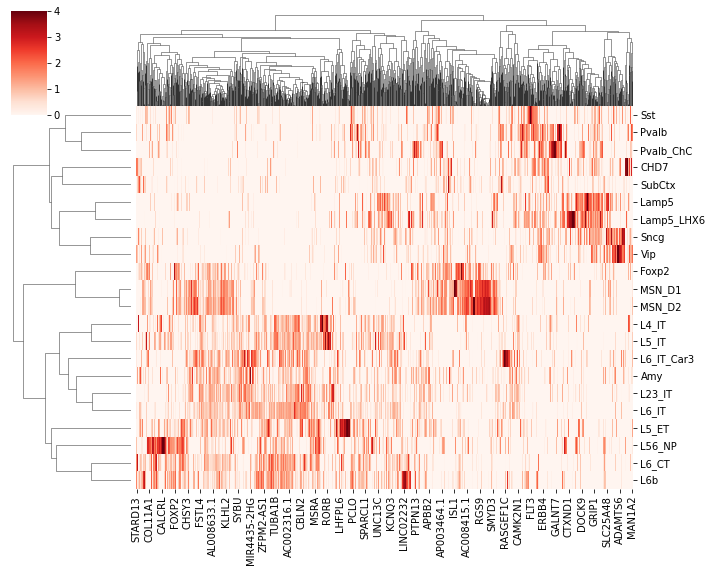

In [43]:
tmp = expr.loc[leg[:22], selg==1]
tmp.columns = adata.var['gene_name'].values[selg==1]
sns.clustermap(tmp, z_score=1, cmap='Reds', vmin=0, vmax=4, metric='cosine', figsize=(10,8))


<AxesSubplot:ylabel='Percent'>

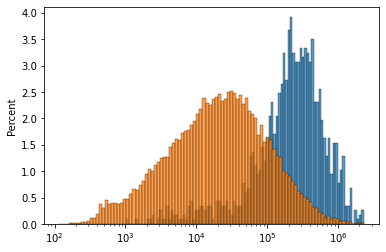

In [44]:
fig, ax = plt.subplots()
sns.histplot(adata.var.loc[selg==1, 'end'] - adata.var.loc[selg==1, 'start'], log_scale=10, bins=100, stat='percent', ax=ax)
sns.histplot(adata.var['end'] - adata.var['start'], log_scale=10, bins=100, stat='percent', ax=ax)


In [46]:
expr.to_hdf(f'{outdir}cluster_expr.hdf', key='data')


In [47]:
selg = np.zeros(adata.shape[1])
for xx in result:
    rank = rankdata(xx[3])
    selg[rank<=100] = 1

print(selg.sum())

1439.0


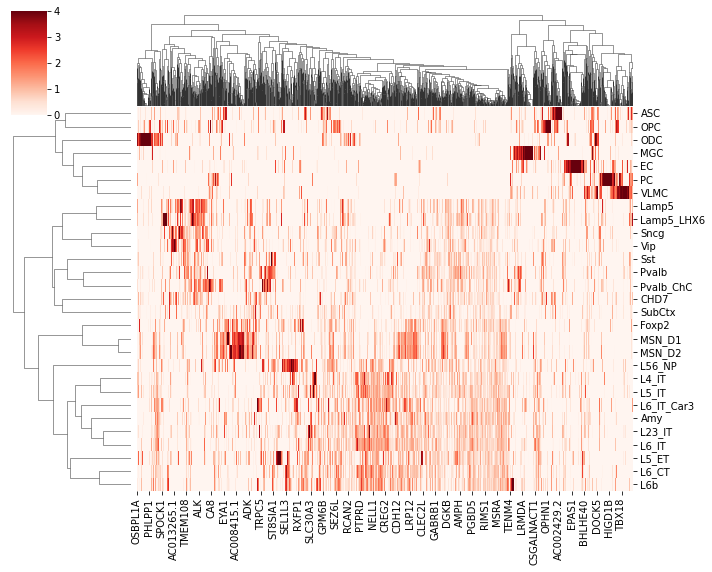

In [48]:
tmp = expr.loc[leg, selg==1]
tmp.columns = adata.var['gene_name'].values[selg==1]
sns.clustermap(tmp, z_score=1, cmap='Reds', vmin=0, vmax=4, metric='cosine', figsize=(10,8))


<AxesSubplot:ylabel='Percent'>

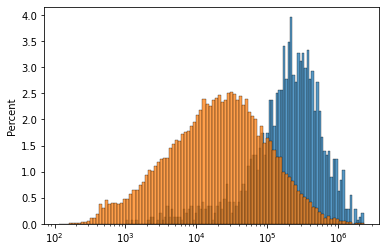

In [49]:
fig, ax = plt.subplots()
sns.histplot(adata.var.loc[selg==1, 'end'] - adata.var.loc[selg==1, 'start'], log_scale=10, bins=100, stat='percent', ax=ax)
sns.histplot(adata.var['end'] - adata.var['start'], log_scale=10, bins=100, stat='percent', ax=ax)
